# Chapter 11 - Training Deep Neural Nets

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os, itertools

In [3]:
from sklearn import datasets

In Chapter 10 we introduced artificial neural networks and trained our first deep neural network. 

But it was a **very shallow DNN**, with only two hidden layers. 

What if you need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images? 

You may need to train a much deeper DNN, perhaps with (say) 10 layers, each containing hundreds of neurons, connected by hundreds of thousands of connections. 

This would not be a walk in the park:

* First, you would be faced with the tricky **vanishing gradients** problem (or the related **exploding gradients** problem) that affects deep neural networks and makes lower layers very hard to train.

* Second, with such a large network, training would be **extremely slow**.

* Third, a model with millions of parameters would severely **risk overfitting** the training set.

we will go through each of these problems in turn and present techniques to solve them.

We will start by explaining the **vanishing gradients problem** and exploring some of the most popular solutions to this problem. 

We will look at **various optimizers** that can speed up training large models tremendously compared to plain Gradient Descent. 

Finally, we will go through a few popular **regularization techniques** for large neural networks.

## Vanishing/Exploding Gradients Problems

The backpropagation algorithm works by going *from the output layer to the input layer*, propagating the error gradient on the way. Once the algorithm has computed the gradient of the
cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often **get smaller and smaller** as the algorithm **progresses down to the lower layers**. As a result, the Gradient Descent update leaves the **lower layer connection weights virtually unchanged**, and training **never converges** to a good solution. 

This is called the ***vanishing gradients*** problem. 

In some cases, the opposite can happen: the gradients can **grow bigger and bigger**, so many
layers get insanely large weight updates and the algorithm **diverges**. 

This is the **exploding gradients** problem, which is mostly encountered in *recurrent neural networks*. 


More generally, deep neural networks suffer from **unstable gradients**; different layers may learn at widely *different speeds*.

Although this unfortunate behavior has been empirically observed for quite a while (it was one of the reasons why deep neural networks were mostly abandoned for a long time), it is only around 2010 that significant progress was made in understanding it. 

A paper titled “Understanding the Difficulty of Training Deep Feedforward Neural Networks” by Xavier Glorot and Yoshua Bengio found a few suspects, including the **combination of the popular logistic sigmoid activation function and the weight initialization technique** that was most popular at the time, namely *random initialization* using a normal distribution with
a mean of 0 and a standard deviation of 1. 

In short, they showed that with this activation function and this initialization scheme: 

*the variance of the outputs of each layer is much greater than the variance of its inputs*. 

**Going forward** in the network, the **variance keeps increasing** after each layer until the activation function saturates at the top layers. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

Looking at the logistic activation function (see Figure 11-1), you can see that **when inputs become large** (negative or positive), the function *saturates at 0 or 1*, with a **derivative extremely close to 0**. 

Thus when backpropagation kicks in, it has virtually **no gradient to propagate back** through the network, and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

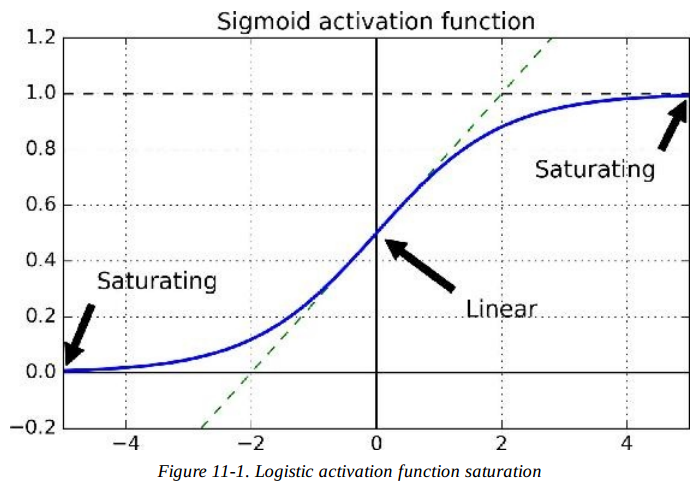

### Xavier and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate this problem. 

We need the signal to flow properly *in both directions*: 

* in the forward direction when making predictions.
* in the reverse direction when backpropagating gradients. 


We don’t want the signal to **die out, nor do we want it to explode and saturate**. 

For the signal to flow properly, the authors argue that we need: 
***the variance of the outputs of each layer to be equal to the variance of its inputs, and we also need the gradients to have equal variance before and after flowing through a layer in the reverse direction***. 

Here’s an analogy:

if you set a microphone amplifier’s knob too close to zero, people won’t hear your voice, but if you set it too close to the max, your voice will be saturated and people won’t understand what you are saying. Now imagine a chain of such amplifiers: they all need to be set properly in order for your voice to come out loud and clear at the end of the chain. Your voice has to come out of each amplifier at the same amplitude as it came in.

It is actually not possible to guarantee both unless **the layer has an equal number of input and output connections**, but they proposed a good compromise that has proven to work very well in practice: 

the connection weights must be **initialized randomly as described in Equation 11-1**, where $n_{inputs}$ and $n_{outputs}$ are the number of input and output connections for the layer whose weights are being initialized (also called **fan-in** and **fan-out**). 

This initialization strategy is often called **Xavier** initialization (after the author’s first name), or sometimes **Glorot** initialization.

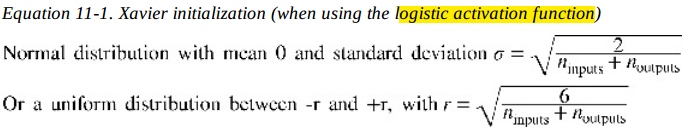

When **the number of input connections is roughly equal to the number of output connections**, you get simpler equations:

$\sigma = \frac{1}{\sqrt{n_{inputs}}}$ or $r = \frac{\sqrt{3}}{\sqrt{n_{inputs}}}$

Using the Xavier initialization strategy can **speed up training considerably**, and it is one of the tricks that led to the current success of Deep Learning. 

Some recent papers (Such as “Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification,” K. He et al. (2015).) have provided similar strategies for **different activation functions**, as shown in Table 11-1. 

The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called **He initialization** (after the last name of its author).

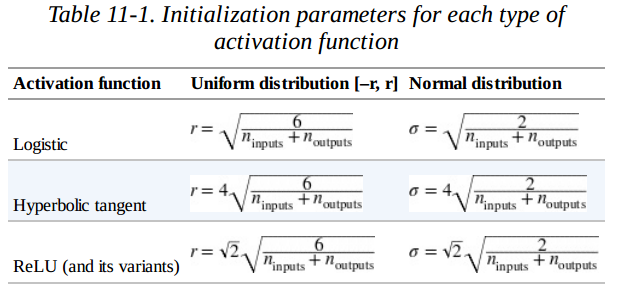

By default, the `tf.layers.dense()` function uses Xavier initialization (with a uniform distribution). You can change this to He initialization by using the `variance_scaling_initializer()` function like this:

In [5]:
he_init = tf.contrib.layers.variance_scaling_initializer()

hidden1 = tf.layers.dense(
    X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1"
)

NameError: name 'tf' is not defined

NOTE

**He** initialization considers *only the fan-in*, not the average between fan-in and fan-out like in Xavier initialization. 

This is also the default for the `variance_scaling_initializer()` function, but you can change this by setting the argument `mode="FAN_AVG"`.

### Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the vanishing/exploding gradients problems were in part due to a *poor choice of activation function*.

Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. 

But it turns out that other activation functions behave much better in deep neural networks, in particular the **ReLU** activation function, mostly because **it does not saturate for
positive values** (and also because it is quite fast to compute).

ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs**: 

During training, some neurons effectively die, meaning *they stop outputting anything* other than 0.

In some cases, you may find that half of your network’s neurons are dead, especially if you used a *large learning rate*. 

During training, if a neuron’s weights get updated such that the **weighted sum of the neuron’s
inputs is negative**, it will start outputting 0. 

When this happen, the neuron **is unlikely to come back to life since the gradient of the ReLU function is 0 when its input is negative**.

To solve this problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**. This function is defined as $LeakyReLU_α(z) = max(αz, z)$ (see Figure 11-2). 


The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0, and is **typically set to 0.01**. 


This small slope ensures that leaky ReLUs *never die*; they can go into a long coma, but they have a chance to eventually wake up. 


A recent paper (“Empirical Evaluation of Rectified Activations in Convolution Network,” B. Xu et al. (2015).) compared several variants of the ReLU activation function and one of its conclusions was that the **leaky variants always outperformed the strict ReLU activation function**. 

In fact, **setting α = 0.2 (huge leak) seemed to result in better performance than α = 0.01 (small leak)**. 


They also evaluated the **randomized leaky ReLU (RReLU)**, where α is picked randomly in a given range during training, and **it is fixed to an average value during testing**. 

It also performed fairly well and seemed to act as a **regularizer** (reducing the risk of overfitting the training set). 

Finally, they also evaluated the **parametric leaky ReLU (PReLU)**, where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). 

This was reported to **strongly outperform ReLU on large image datasets**, but on smaller
datasets it runs the *risk of overfitting the training set*.

Last but not least, a 2015 paper by Djork-Arné Clevert et al.6 proposed a new activation function called the **exponential linear unit (ELU)** that **outperformed all the ReLU** variants in their experiments: training time was reduced and the neural network performed better on the test set. It is represented in Figure 11-3, and Equation 11-2 shows its definition.


It looks a lot like the ReLU function, with a few major differences:

1. It takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem, as discussed earlier. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter if you want.

2. Second, it has a nonzero gradient for z < 0, which avoids the dying units issue.

3. The function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent, since it does not bounce as much left and right of z = 0.

The **main drawback** of the ELU activation function is that **it is slower to compute than the ReLU and its variants** (due to the use of the exponential function), but during training this is compensated by **the faster convergence rate**. 

However, at test time an ELU network will be slower than a ReLU network.

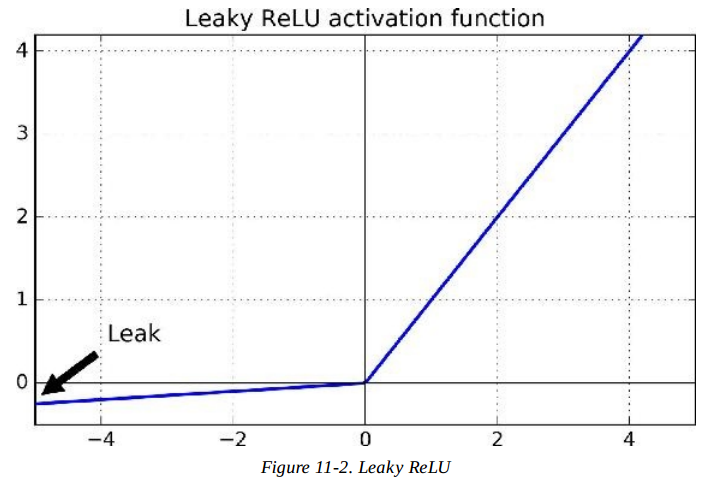

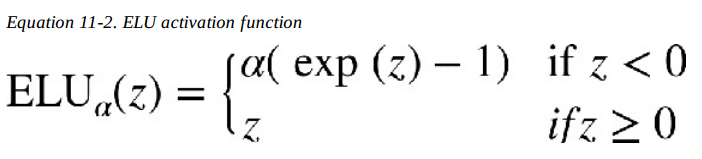

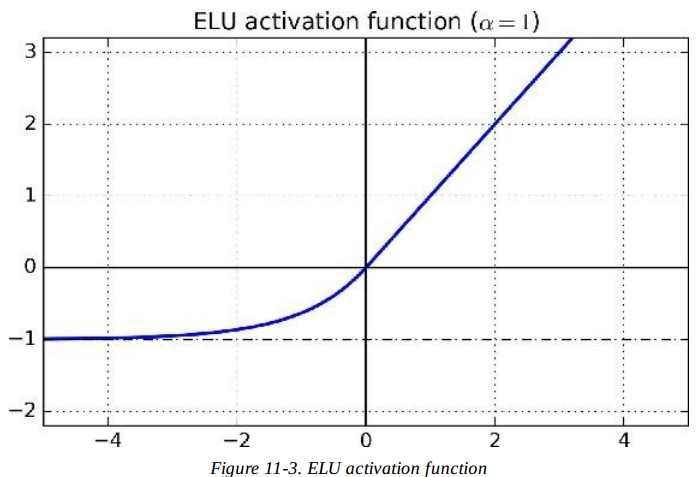

TIP

So which activation function should you use for the hidden layers of your deep neural networks? 

Although your mileage will vary, in general 

**ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic**. 


If you **care a lot about runtime performance**, then you may prefer leaky ReLUs over ELUs. 

If you don’t want to tweak yet another hyperparameter, you may just use the default α values suggested earlier (0.01 for the leaky ReLU, and 1 for ELU). 

If you have spare time and computing power, you can **use cross-validation** to evaluate other activation functions, in particular 

RReLU if your network is overfitting

or PReLU if you have a huge training set.

TensorFlow offers an `elu()` function that you can use to build your neural network. Simply set the activation argument when calling the `dense()` function, like this:

In [6]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

NameError: name 'tf' is not defined

TensorFlow does not have a predefined function for leaky ReLUs, but it is easy enough to define:

In [7]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)


hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

NameError: name 'tf' is not defined

### Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems **at the beginning of training**, it doesn’t guarantee that they won’t come back **during training**.


In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called **Batch Normalization (BN)** to address the vanishing/exploding gradients problems, and more generally the problem that **the distribution of each layer’s inputs changes during training**, as the parameters of the previous layers change (which they call the **Internal Covariate Shift problem**).


The technique consists of **adding an operation in the model *just before* the activation function of each layer**, simply *zero-centering* and *normalizing the inputs*, then *scaling and shifting* the result using two new parameters per layer (one for scaling, the other for shifting). 

In other words, this operation lets the model learn **the optimal scale and mean of the inputs for each layer**.


In order to zero-center and normalize the inputs, the algorithm needs to **estimate the inputs’ mean and standard deviation**. 

It does so by evaluating the mean and standard deviation of the inputs **over the current
mini-batch** (hence the name “Batch Normalization”). 

The whole operation is summarized in Equation 11-3:

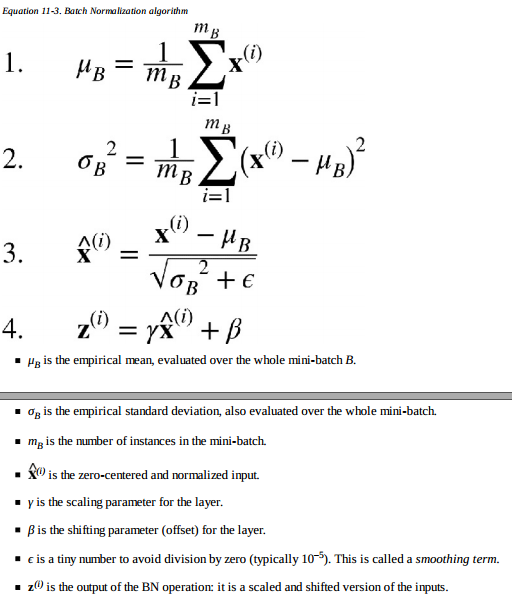

**At test time**, there is **no mini-batch** to compute the empirical mean and standard deviation, so instead you **simply use the whole training set’s mean and standard deviation**. 

These are typically efficiently computed during training using a *moving average*. 
So, in total, four parameters are learned for each batch normalized layer: 

γ (scale), β (offset), μ (mean), and σ (standard deviation).


The authors demonstrated that this technique considerably **improved all the deep neural networks** they experimented with. 

The **vanishing gradients problem was strongly reduced**, to the point that they could use
saturating activation functions such as the *tanh* and even the *logistic activation function*. 


The networks were also much **less sensitive to the weight initialization**. 

They were able to **use much larger learning rates**, significantly speeding up the learning process. Specifically, they note that 

*"Applied to a state-ofthe-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […] Using an ensemble of batch normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters."* 

Finally,  Batch Normalization also acts like a **regularizer**, reducing the need for other
regularization techniques (such as dropout, described later in the chapter).

Batch Normalization does, however, *add some complexity to the model* (although it removes the need for normalizing the input data since the first hidden layer will take care of that, provided it is batchnormalized). 

Moreover, there is a runtime penalty: the neural network makes **slower predictions** due to
the extra computations required at each layer. 

So if you need predictions to be lightning-fast, you may want to check how well plain **ELU + He initialization** perform before playing with Batch Normalization.

NOTE

You may find that training is rather slow at first while Gradient Descent is searching for the optimal scales and offsets for each layer, but **it accelerates once it has found reasonably good values**.

#### Implementing Batch Normalization with TensorFlow

TensorFlow provides a `tf.nn.batch_normalization()` function that simply centers and normalizes the inputs, but you must compute the mean and standard deviation yourself (based on the mini-batch data during training or on the full dataset during testing, as just discussed) and pass them as parameters to this function, and you must also handle the creation of the scaling and offset parameters (and pass them to this function). 

It is doable, but not the most convenient approach. 

Instead, you should use the `tf.layers.batch_normalization()` function, which handles all this for you, as in the following code:

In [8]:
import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name="training")

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(
    logits_before_bn, training=training, momentum=0.9
)

ModuleNotFoundError: No module named 'tensorflow'

The first lines are fairly self-explanatory, until we define the training placeholder:

We will set it to True during training, but otherwise it will default to False. 

This will be used to tell the `tf.layers.batch_normalization()` function whether it should use the **current minibatch’s mean and standard deviation (during training)** or the **whole training set’s mean and standard deviation (during testing)**.

Then, we alternate fully connected layers and batch normalization layers: the fully connected layers are created using the `tf.layers.dense()` function. 

Note that **we don’t specify any activation function** for the fully connected layers because we want to apply the activation function after each batch normalization layer.(Many researchers argue that it is just as good, or even better, to place the batch normalization layers after (rather than before) the activations.) 

We create the batch normalization layers using the `tf.layers.batch_normalization()` function, setting its `training` and `momentum` parameters. 

The BN algorithm uses **exponential decay** to compute the running averages, which is why it requires the `momentum` parameter: given a new value $v$, the running average $\hat v$ is updated through the equation:

$\hat v \leftarrow \hat v  * momentum + v * (1-momentum)$

A good `momentum` value is typically close to 1 — for example, 0.9, 0.99, or 0.999 (you want **more 9s for larger datasets and smaller mini-batches**).

You may have noticed that the code is quite repetitive, with the same batch normalization parameters appearing over and over again. 

To *avoid this repetition*, you can use the `partial()` function from the `functools` module (part of Python’s standard library). It creates a thin wrapper around a function and allows you to define default values for some parameters. The creation of the network layers in the
preceding code can be modified like so:

In [1]:
from functools import partial

my_batch_norm_layer = partial(
    tf.layers.batch_normalization, training=training, momentum=0.9
)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

NameError: name 'tf' is not defined

The rest of the construction phase is the same as in Chapter 10: 

* define the cost function
* create an optimizer
* tell it to minimize the cost function
* define the evaluation operations, create a Saver, and so on.

The **execution phase** is also pretty much the same, with two exceptions: 

* First, during training, whenever you run an operation that depends on the `batch_normalization()` layer, you need to set the training placeholder to True. 

* Second, the `batch_normalization()` function creates a few operations that must be evaluated at each step during training in order to update the moving averages (recall that these moving averages are needed to evaluate the training set’s mean and standard deviation). These operations are automatically added to the `UPDATE_OPS` collection, so all we need to do is get the list of operations in that collection and run them at each training iteration:

In [3]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):

            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(
                [training_op, extra_update_ops],
                feed_dict={training: True, X: X_batch, y: y_batch},
            )

        accuracy_val = accuracy.eval(
            feed_dict={X: mnist.test.images, y: mnist.test.labels}
        )

        print(epoch, "Test accuracy:", accuracy_val)

save_path = saver.save(sess, "./my_model_final.ckpt")

NameError: name 'tf' is not defined

## Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply *clip the gradients during backpropagation* so that they never exceed some threshold (this is mostly useful for recurrent neural networks). This is called **Gradient Clipping** (“On the difficulty of training recurrent neural networks,” R. Pascanu et al. (2013)). 


In general people now **prefer Batch Normalization**, but it’s still useful to know about Gradient Clipping and how to implement it.

In TensorFlow, the optimizer’s `minimize()` function takes care of both computing the gradients and applying them, so you must instead call the optimizer’s `compute_gradients()` method first, then create an operation to clip the gradients using the `clip_by_value()` function, and finally create an operation to apply the clipped gradients using the optimizer’s `apply_gradients()` method:

In [4]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(loss)

capped_gvs = [
    (tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars
]

training_op = optimizer.apply_gradients(capped_gvs)

NameError: name 'tf' is not defined

You would then run this `training_op` at every training step, as usual. It will compute the gradients, clip them between –1.0 and 1.0, and apply them. The threshold is a hyperparameter you can tune.

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to **find an existing neural network** that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called **transfer learning**. 


It will not only speed up training considerably, but will also **require much less training** data.

For example, suppose that you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. 

You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, so you should try to reuse parts of the first network (see Figure 11-4).

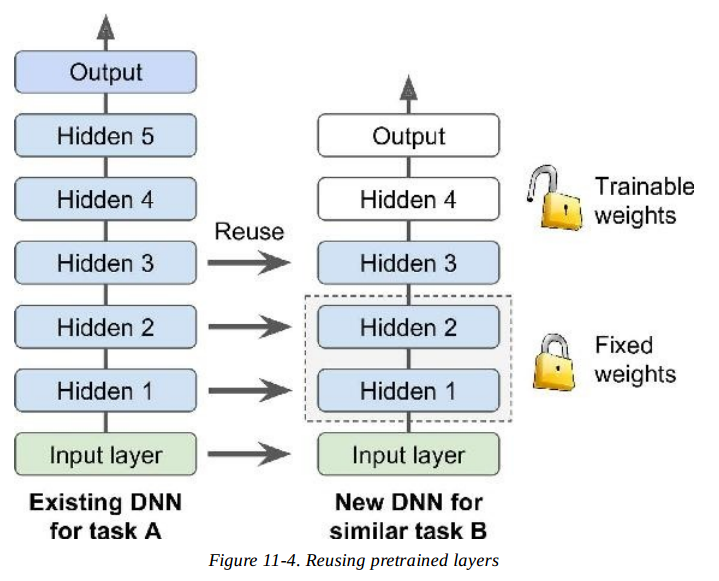

NOTE

If the input pictures of your new task don’t have the same size as the ones used in the original task, you will have to **add a preprocessing step to resize them** to the size expected by the original model. More generally, **transfer learning will only work well
if the inputs have similar low-level features.**

### Reusing a TensorFlow Model

If the original model was trained using TensorFlow, you can simply restore it and train it on the new task.
As we discussed in Chapter 9, you can use the `import_meta_graph()` function to import the operations into the **default graph**. This returns a `Saver` that you can later use to load the model’s state:

In [5]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

NameError: name 'tf' is not defined

You must then get a handle on the operations and tensors you will need for training. For this, you can use the graph’s `get_operation_by_name()` and `get_tensor_by_name()` methods. 

The *name of a tensor* is the name of the operation that outputs it followed by :0 (or :1 if it is the second output, :2 if it is the third, and so on):

In [6]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

NameError: name 'tf' is not defined

If the pretrained model is not well documented, then you will have to explore the graph to find the names of the operations you will need. 

In this case, you can either explore the graph using 

* TensorBoard (for this you must first export the graph using a `FileWriter`, as discussed in Chapter 9)

* you can use the graph’s `get_operations()` method to list all the operations:

In [7]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

NameError: name 'tf' is not defined

If you are the **author of the original model**, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to *create a collection containing all the important operations* that people will want to get a handle on:

In [8]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

NameError: name 'X' is not defined

This way people who reuse your model will be able to simply write:

In [9]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

NameError: name 'tf' is not defined

You can then **restore the model’s state** using the `Saver` and **continue training** using your own data:

In [11]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    [...]  # train the model on your own data

NameError: name 'tf' is not defined

Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`.

In general, you will want to reuse **only part of the original model**, typically the lower layers. 

If you use `import_meta_graph()` to restore the graph, it will **load the entire original graph**, but nothing prevents you from just ignoring the layers you do not care about. 

For example, as shown in Figure 11-4, you could **build new layers** (e.g., one hidden layer and one output layer) on top of a pretrained layer (e.g., pretrained hidden layer 3). You would also need to **compute the loss for this new output**, and create an optimizer to minimize that loss.

If you have access to the pretrained graph’s Python code, you can just reuse the parts you need and chop out the rest. However, in this case you need a `Saver` to restore the pretrained model (specifying which variables you want to restore; otherwise, TensorFlow will complain that the graphs do not match), and another `Saver` to save the new model. For example, the following code restores only hidden layers 1, 2, and 3:

In [12]:
[...]  # build the new model with the same hidden layers 1-3 as before

reuse_vars = tf.get_collection(
    tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]"
)  # regular expression

reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict)  # to restore layers 1-3

init = tf.global_variables_initializer()  # to init all variables, old and new
saver = tf.train.Saver()  # to save the new model

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    [...]  # train the model
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

NameError: name 'tf' is not defined

First we build the new model, making sure to copy the original model’s hidden layers 1 to 3. 

Then we get the list of all variables in hidden layers 1 to 3, using the regular expression "hidden[123]". 

Next, we create a dictionary that maps the name of each variable in the original model to its name in the new model (generally you want to keep the exact same names). 

Then we create a `Saver` that will restore only these variables. We also create an operation to initialize all the variables (old and new) and a second `Saver` to save the entire new model, not just layers 1 to 3. We then start a session and initialize all variables in the model, then restore the variable values from the original model’s layers 1 to 3. 

Finally, we train the model on the new task and save it.

**TIP**

The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, you can try keeping all the hidden layers and just replace the output layer.

### Reusing Models from Other Frameworks

If the model was trained using **another framework**, you will need to load the **model parameters manually** (e.g., using Theano code if it was trained with Theano), then assign them to the appropriate variables.

This can be quite tedious. For example, the following code shows how you would copy the weight and biases from the first hidden layer of a model trained using another framework:

In [13]:
original_w = [...]  # Load the weights from the other framework
original_b = [...]  # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
[...]  # Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task

NameError: name 'tf' is not defined

In this implementation, we first load the pretrained model using the other framework (not shown here), and we extract from it the model parameters we want to reuse. 

Next, we build our TensorFlow model as usual. 

Then comes the tricky part: every TensorFlow variable has an **associated assignment operation** that is used to **initialize it**. 

We start by getting a handle on these assignment operations (they have the same name as the variable, plus `"/Assign"`).

We also get a handle on each assignment operation’s second input: in the case of an assignment operation, the second input corresponds to the value that will be assigned to the variable, so in this case it is the variable’s initialization value. 

Once we start the session, we run the usual initialization operation, but this time we feed it the values we want for the variables we want to reuse. Alternatively, we could have created new assignment operations and placeholders, and used them to set the values of the variables after initialization. But why create new nodes in the graph when everything we need is already there?

### Freezing the Lower Layers

It is likely that the **lower layers** of the first DNN have learned to detect **low-level features** in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are. It is generally a good idea to **“freeze”** their weights when training the new DNN: if the lower-layer weights are fixed, then the **higher-layer weights will be easier to train** (because they won’t have to learn a moving target). To freeze the lower layers during training, one solution is to **give the optimizer the list of variables to train, excluding the variables from the lower layers**:

In [14]:
train_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs"
)

training_op = optimizer.minimize(loss, var_list=train_vars)

NameError: name 'tf' is not defined

The first line gets the list of all trainable variables in hidden layers 3 and 4 and in the output layer. This leaves out the variables in the hidden layers 1 and 2. 

Next we provide this restricted list of trainable variables to the optimizer’s `minimize()` function. 

Layers 1 and 2 are now frozen: they will not budge during training (these are often called **frozen layers**).

Another option is to add a `stop_gradient()` layer in the graph. Any layer below it will be frozen:

In [15]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(
        X, n_hidden1, activation=tf.nn.relu, name="hidden1"
    )  # reused frozen

    hidden2 = tf.layers.dense(
        hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2"
    )  # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)

    hidden3 = tf.layers.dense(
        hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3"
    )  # reused, not frozen

    hidden4 = tf.layers.dense(
        hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4"
    )  # new!

    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")  # new!

NameError: name 'tf' is not defined

### Caching the Frozen Layers

Since the frozen layers won’t change, it is possible to **cache the output** of the topmost frozen layer for each training instance. Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through the frozen layers once per training instance (instead of once per epoch). For example, you could first run the whole training set through the lower layers (assuming you have enough RAM), then during training, instead of building batches of training instances, you would build batches of outputs from hidden layer 2 and feed them to the training operation:

In [16]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)

        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

NameError: name 'mnist' is not defined

The last line of the training loop runs the training operation defined earlier (which does not touch layers 1 and 2), and feeds it a batch of outputs from the second hidden layer (as well as the targets for that batch).

Since we give TensorFlow the output of hidden layer 2, it does not try to evaluate it (or any node it depends on)

### Tweaking, Dropping, or Replacing the Upper Layers

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

Try freezing all the copied layers first, then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freeze all remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

### Model Zoos

Where can you find a neural network trained for a task similar to the one you want to tackle? 

The first place to look is obviously in your own catalog of models. This is one good reason to save all your models and organize them so you can retrieve them later easily. 

Another option is to search in a **model zoo**. Many people train Machine Learning models for various tasks and kindly release their pretrained models to the public.

TensorFlow has its own model zoo available at https://github.com/tensorflow/models. 

In particular, it contains most of the state-of-the-art image classification nets such as VGG, Inception, and ResNet (see Chapter 13, and check out the models/slim directory), including the code, the pretrained models, and tools to download popular image datasets.

Another popular model zoo is *Caffe’s Model Zoo*. It also contains many computer vision models (e.g., LeNet, AlexNet, ZFNet, GoogLeNet, VGGNet, inception) trained on various datasets (e.g., ImageNet, Places Database, CIFAR10, etc.). Saumitro Dasgupta wrote a converter, which is available at https://github.com/ethereon/caffe-tensorflow.

### Unsupervised Pretraining

Suppose you want to tackle a complex task for which **you don’t have much labeled training data**, but unfortunately you cannot find a model trained on a similar task. Don’t lose all hope! 

First, you should of course try to gather more labeled training data, but if this is too hard or too expensive, you may still be able to perform **unsupervised pretraining** (see Figure 11-5):

That is, if you have **plenty of unlabeled training data**, you can try to **train the layers one by one**, starting with the lowest layer and then going up, using an **unsupervised feature detector** algorithm such as Restricted Boltzmann Machines (RBMs; see Appendix E) or autoencoders (see Chapter 15). Each layer is trained on the **output of the previously trained layers** (all layers except the one being trained are frozen). Once all layers have been trained this way, you can fine-tune the network using supervised learning (i.e., with backpropagation).

This is a rather long and tedious process, but it often works well; in fact, it is this technique that Geoffrey Hinton and his team used in 2006 and which led to the revival of neural networks and the success of Deep Learning. Until 2010, unsupervised pretraining (typically using RBMs) was the norm for deep nets, and it was only after the vanishing gradients problem was alleviated that it became much more common to train DNNs purely using backpropagation. However, unsupervised pretraining (today typically using autoencoders rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.


*Another option is to come up with a supervised task for which you can easily gather a lot of labeled training data, then use transfer learning, as explained earlier. For example, if you want to train a model to identify your friends in pictures, you could download millions of faces on the internet and train a classifier to detect whether two faces are identical or not, then use this classifier to compare a new picture with each picture of your friends.*

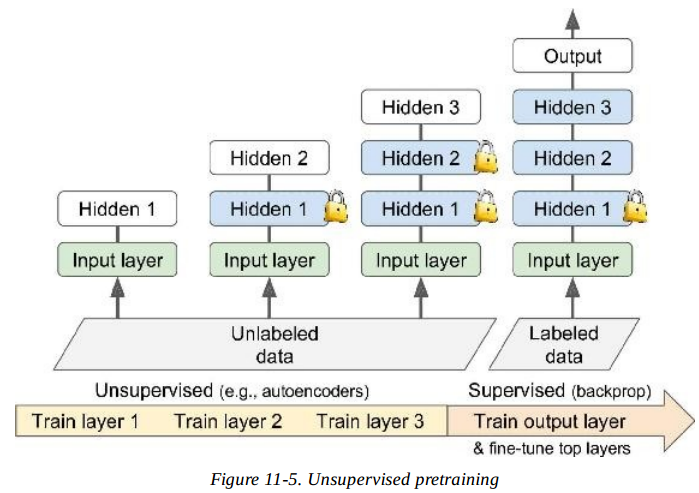

### Pretraining on an Auxiliary Task

One last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.
For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual — clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. However, you could gather a lot of pictures of random people on the internet and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier using little training data.
It is often rather cheap to gather unlabeled training examples, but quite expensive to label them. In this situation, a common technique is to label all your training examples as “good,” then generate many new training instances by corrupting the good ones, and label these corrupted instances as “bad.” Then you can train a first neural network to classify instances as good or bad. For example, you could download millions of sentences, label them as “good,” then randomly change a word in each sentence and label the resulting sentences as “bad.” If a neural network can tell that “The dog sleeps” is a good sentence but “The dog they” is bad, it probably knows quite a lot about language. Reusing its lower layers will likely
help in many language processing tasks.
Another approach is to train a first network to output a score for each training instance, and use a cost function that ensures that a good instance’s score is greater than a bad instance’s score by at least some margin. This is called max margin learning.

## Faster Optimizers

Training a very large deep neural network can be painfully slow. 

So far we have seen four ways to speed up training (and reach a better solution): 

* applying a good initialization strategy for the connection weights
* using a good activation function
* using Batch Normalization 
* reusing parts of a pretrained network.

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent
optimizer. In this section we will present the most popular ones: 

* Momentum optimization
* Nesterov Accelerated Gradient
* AdaGrad
* RMSProp
* Adam optimization.

### Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind Momentum optimization, proposed by Boris Polyak in 1964.

In contrast, regular Gradient Descent will simply *take small regular* steps down the slope, so it will take much more time to reach the bottom.

Recall that Gradient Descent simply updates the weights θ by directly subtracting the gradient of the cost function J(θ) with regards to the weights ( $\nabla_θJ(θ)$) multiplied by the learning rate η. 

The equation is: θ ← θ – η θJ(θ). 

It does not care about **what the earlier gradients were**. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about **what previous gradients** were: 

at each iteration, it **subtracts the local gradient from the momentum vector** $m$ (multiplied by the learning rate η), and it updates the weights by simply adding this momentum vector (see Equation 11-4). 

In other words, the **gradient is used as an acceleration**, not as a speed. To simulate some sort of **friction mechanism** and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, simply called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

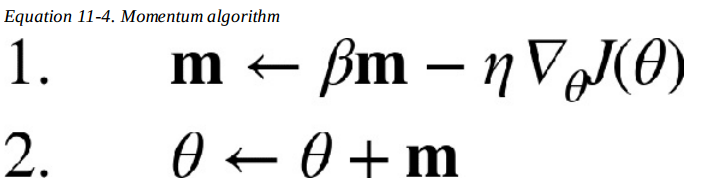

You can easily verify that if the *gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate η multiplied by $\frac{1}{\beta-1}$ (ignoring the sign)*. 

For example, if β = 0.9, then the terminal velocity is equal to 10 times the gradient times the
learning rate, so Momentum optimization ends up going 10 times faster than Gradient Descent! 

This allows Momentum optimization to **escape from plateaus** much faster than Gradient Descent. 

In particular, we saw in Chapter 4 that when the inputs have very different scales the cost function will look like an elongated bowl (see Figure 4-7). Gradient Descent goes down the steep slope quite fast, but then it takes a very long time to go down the valley. 

In contrast, Momentum optimization will roll down the bottom of the valley faster and faster until it reaches the bottom (the optimum). In deep neural networks that don’t use Batch Normalization, the upper layers will often end up having inputs with very different scales, so
using Momentum optimization helps a lot. It can also help roll past local optima.